<a href="https://colab.research.google.com/github/Bhargavi1504/supply-unsupervised/blob/main/Unsupervised_supply.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Title: “Advanced Supply Chain Optimization using Unsupervised Learning: Detecting Anomalies, Clustering Warehouses, and Pattern Mining”

🎯 Objective: To simulate a multi-level supply chain system and apply all major unsupervised algorithms to:

Cluster warehouses & routes

Detect anomalies in delivery

Mine patterns in item movement

Perform dimensionality reduction for visualization

Understand supplier-product distribution

In [9]:
#warehouse--dataset

import numpy as np
import pandas as pd
import random
np.random.seed(42)

#no.of warehouses
n_warehouses=100

#fields
warehouse_id=[f'WR{1000+i}' for i in range(n_warehouses)]
locations=['North','South','East','West','Central']
storage_types=['cold','Dry','Frozen']
size_soft=np.random.normal(loc=50000,scale=15000,size=n_warehouses).astype(int)
avg_dispatch=np.random.poisson(lam=200,size=n_warehouses).astype(float)
manager_exp=np.random.randint(1,20,n_warehouses)

#noise
noise=np.random.normal(loc=0.0,scale=0.1*avg_dispatch,size=n_warehouses)
avg_dispatch_noisy=avg_dispatch + noise

#outliers
outlier_indices=np.random.choice(n_warehouses,size=5,replace=False)
for i in outlier_indices:
  if random.random()>0.5:
    avg_dispatch_noisy[i] *= np.random.uniform(1.5,2.0)   #spike
  else:
    avg_dispatch_noisy[i] *= np.random.uniform(0.2,0.5)   #drop

#clip negative values
avg_dispatch_noisy = np.clip(avg_dispatch_noisy,10,None)


warehouse_id=[f'WR{1000+i}' for i in range(n_warehouses)]
locations=['North','South','East','West','Central']
storage_types=['cold','Dry','Frozen']
size_sqft=np.random.normal(loc=50000,scale=15000,size=n_warehouses).astype(int)
avg_dispatch=np.random.poisson(lam=200,size=n_warehouses).astype(float)
manager_exp=np.random.randint(1,20,n_warehouses)

#noise

#Now dataframe
d_wh=pd.DataFrame({
    'warehouse_id': warehouse_id,
    'Location': np.random.choice(locations,n_warehouses),
    'size-sqft' : np.clip(size_soft,10000,None),
    'storage-type': np.random.choice(storage_types,n_warehouses),
    'avg_dispatch_per_day': avg_dispatch_noisy.round(2),
    'manager-experience': manager_exp
})

#saving
d_wh.to_csv('warehouses.csv',index=False)
print(d_wh.head())

  warehouse_id Location  size-sqft storage-type  avg_dispatch_per_day  \
0       WR1000     East      57450       Frozen                165.84   
1       WR1001    South      47926         cold                182.43   
2       WR1002  Central      59715         cold                253.29   
3       WR1003  Central      72845         cold                205.77   
4       WR1004  Central      46487          Dry                187.84   

   manager-experience  
0                  19  
1                   5  
2                  12  
3                  17  
4                  17  


In [10]:
#products.csv- dataset

np.random.seed(42)

n_products=500
n_suppliers=30

#no. of products and suppliers
product_id = [f'PRD{1000+i}' for i in range(n_products)]

supplier_id=[f'{500+i}' for i in range(n_suppliers)]

#product category with its characteristics
categories={
    'Food' : {'weight_mean': 5,'weight_std' : 2,'pershability': (0.7,1.0)},
    'Electronics' : {'weight_mean':2,'weight_std':1,'pershability':(0.0,0.2)},
    'Apparel': {'weight_mean':1,'weight_std':0.5,'pershability':(0.0,0.3)},
    'Chemicals': {'weight_mean':10,'weight_std':5,'pershability':(0.5,0.9)},
    'Machinery': {'weight_mean':100,'weight_std':50,'pershability':(0.0,0.1)},
}
#assigning categories to products
category_choice=np.random.choice(list(categories.keys()),n_products)

#product features
weights=[]
perish_score=[]
for i in category_choice:
  w=np.random.normal(loc=categories[i]['weight_mean'],scale=categories[i]['weight_std'])
  w=max(0.1,w)   #to ensure no negative weights
  weights.append(round(w,2))

  perish=np.random.uniform(*categories[i]['pershability'])
  perish_score.append(round(perish,2))

#assigning suppliers
product_suppliers=np.random.choice(supplier_id,n_products)

#dataframe
d_p=pd.DataFrame({
    'product_id': product_id,
    'category': category_choice,
    'weight_kg': weights,
    'pershability_score': perish_score,
    'supplier_id_':product_suppliers
})

#saving
d_p.to_csv('products.csv',index=False)
print(d_p.head())


  product_id   category  weight_kg  pershability_score supplier_id_
0    PRD1000  Chemicals      16.53                0.63          509
1    PRD1001  Machinery     101.05                0.09          506
2    PRD1002    Apparel       1.16                0.29          512
3    PRD1003  Machinery      93.49                0.06          506
4    PRD1004  Machinery      59.09                0.03          523


In [11]:
#suppliers.csv
np.random.seed(42)

#suppliers in products table
d_products=pd.read_csv('products.csv')

supplier_id_unique=d_products['supplier_id_'].unique()
n_suppliers=len(supplier_id_unique)
# Regions
regions = ['North', 'South', 'East', 'West', 'Central']

supplier_data = {
    'supplier_id': supplier_id_unique,
    'region': np.random.choice(regions,n_suppliers),
    'avg_rating': np.round(np.random.uniform(2.5,5.0,size=n_suppliers),2),
    'compliance_score': np.round(np.random.beta(a=2,b=1.5,size=n_suppliers),2)
}

#dataframe
d_s=pd.DataFrame(supplier_data)

#Add product count
product_count=d_products['supplier_id_'].value_counts()
d_s['total_products_supplied'] = d_s['supplier_id'].map(product_count)


#saving
d_s.to_csv('suppliers.csv',index=False)
print(d_s.head())

   supplier_id   region  avg_rating  compliance_score  total_products_supplied
0          509     West        3.42              0.45                       21
1          506  Central        3.64              0.81                       19
2          512     East        4.46              0.51                       20
3          523  Central        3.00              0.51                       15
4          516  Central        3.79              0.70                       17


In [12]:
#shipment-dataset ----| shipment_id | product_id | warehouse_id | dispatch_time | arrival_time | distance_km | transport_type | delivery_status |
from datetime import timedelta
np.random.seed(42)
n_shipments=10000

#loading data
d_wareh= pd.read_csv('warehouses.csv')
d_pd=pd.read_csv('products.csv')
d_sup=pd.read_csv('suppliers.csv')

#fields
shipment_ids=[f'SHP{10000+i}' for i in range(n_shipments)]

product_ids=d_pd['product_id'].tolist()
warehouse_ids=d_wh['warehouse_id'].tolist()
supplier_ids=d_sup['supplier_id'].tolist()

product_choices=np.random.choice(product_ids,n_shipments)
warehouse_choices=np.random.choice(warehouse_id,n_shipments)
supplier_choices=np.random.choice(supplier_id,n_shipments)

transport_modes = ['Road', 'Air', 'Sea', 'Rail']
transport_choices=np.random.choice(transport_modes,n_shipments)
#distances
transport_distances = {
    'Road': (50, 800),
    'Air': (300, 3000),
    'Sea': (500, 10000),
    'Rail': (200, 2000)
}
distance_km=[]
for i in transport_choices:
  d_sh=np.random.uniform(*transport_distances[i])
  distance_km.append(round(d_sh,2))

#simulate dispatch time
start_time=pd.Timestamp('2023-01-01')
dispatch_dates=[start_time + pd.Timedelta(days=int(x)) for x in np.random.uniform(0,100,n_shipments)]

# Arrival time = dispatch + travel time based on distance and transport type
arrival_times = []
delivery_status = []

for i in range(n_shipments):
    dispatch = dispatch_dates[i]
    mode = transport_choices[i]
    dist = distance_km[i]

    # Average speed per transport (km/h)
    speeds = {'Road': 60, 'Air': 500, 'Sea': 40, 'Rail': 80}
    travel_hours = dist / speeds[mode]
    travel_days = travel_hours / 24

    # Add base time to dispatch
    arrival = dispatch + timedelta(days=travel_days)

    # Inject delay or loss
    rand = np.random.rand()
    if rand < 0.85:
        status = 'On-Time'
    elif rand < 0.97:
        status = 'Delayed'
        delay_days = np.random.uniform(1, 5)
        arrival += timedelta(days=delay_days)
    else:
        status = 'Lost'
        arrival = pd.NaT  # No arrival for lost shipments

    arrival_times.append(arrival)
    delivery_status.append(status)



# Build DataFrame
d_shipments = pd.DataFrame({
    'shipment_id': shipment_ids,
    'product_id': product_choices,
    'supplier_id': supplier_choices,
    'warehouse_id': warehouse_choices,
    'dispatch_time': dispatch_dates,
    'arrival_time': arrival_times,
    'distance_km': distance_km,
    'transport_type': transport_choices,
    'delivery_status': delivery_status
})


# Save
d_shipments.to_csv('shipments.csv', index=False)
print(d_shipments.head())

  shipment_id product_id supplier_id warehouse_id dispatch_time  \
0    SHP10000    PRD1102         525       WR1053    2023-01-02   
1    SHP10001    PRD1435         513       WR1012    2023-03-13   
2    SHP10002    PRD1348         521       WR1082    2023-01-10   
3    SHP10003    PRD1270         500       WR1028    2023-02-21   
4    SHP10004    PRD1106         525       WR1002    2023-02-26   

                arrival_time  distance_km transport_type delivery_status  
0 2023-01-03 05:07:53.400000      1165.26            Sea         On-Time  
1 2023-03-20 02:13:07.500000      6808.75            Sea         On-Time  
2 2023-01-10 14:22:53.400000      1150.52           Rail         On-Time  
3 2023-02-26 09:29:34.243132       670.72           Road         Delayed  
4 2023-02-28 17:16:12.000000      2610.80            Sea         On-Time  


In [13]:
#PHASE 1: Data Understanding & Preparation

#Step 1: Load All 4 Datasets
import pandas as pd
# Load datasets
d_warehouses = pd.read_csv('warehouses.csv')
d_products=pd.read_csv('products.csv')
d_sup=pd.read_csv('suppliers.csv')
d_ship=pd.read_csv('shipments.csv')

#Step 2: Initial Inspection (EDA)
# Check shapes
print("Warehouses:", d_warehouses.shape)
print("Products:", d_products.shape)
print("Suppliers:", d_sup.shape)
print("Shipments:", d_ship.shape)

# Preview datasets
print("\nWarehouses:")
print(d_warehouses.head())
print("\nProducts:")
print(d_products.head())
print("\nSuppliers:")
print(d_sup.head())
print("\nShipments:")
print(d_ship.head())

#Step 3: Check for Nulls & Dtypes
# Null check
print("\nMissing values:")
print("Warehouses:\n", d_warehouses.isnull().sum())
print("Products:\n", d_products.isnull().sum())
print("Suppliers:\n", d_sup.isnull().sum())
print("Shipments:\n", d_ship.isnull().sum())

# Dtype check
print("\nWarehouses:")
print(d_warehouses.dtypes)
print("\nProducts:")
print(d_products.dtypes)
print("\nSuppliers:")
print(d_sup.dtypes)
print("\nShipments:")
print(d_ship.dtypes)

#Step 4: Convert dispatch_time & arrival_time to datetime
d_ship['dispatch_time'] = pd.to_datetime(d_ship['dispatch_time'])
d_ship['arrival_time'] = pd.to_datetime(d_ship['arrival_time'])



#Step 5: Merge All into a Master Table
df = d_ship.merge(d_products, on='product_id', how='left') \
           .merge(d_warehouses, on='warehouse_id', how='left') \
           .merge(d_sup, on='supplier_id', how='left')

print("Merged dataset shape:", df.shape)
print(df.head())


# Step 6: Save Master File (optional)
df.to_csv('master_supply_chain.csv', index=False)
print(df.columns)


Warehouses: (100, 6)
Products: (500, 5)
Suppliers: (30, 5)
Shipments: (10000, 9)

Warehouses:
  warehouse_id Location  size-sqft storage-type  avg_dispatch_per_day  \
0       WR1000     East      57450       Frozen                165.84   
1       WR1001    South      47926         cold                182.43   
2       WR1002  Central      59715         cold                253.29   
3       WR1003  Central      72845         cold                205.77   
4       WR1004  Central      46487          Dry                187.84   

   manager-experience  
0                  19  
1                   5  
2                  12  
3                  17  
4                  17  

Products:
  product_id   category  weight_kg  pershability_score  supplier_id_
0    PRD1000  Chemicals      16.53                0.63           509
1    PRD1001  Machinery     101.05                0.09           506
2    PRD1002    Apparel       1.16                0.29           512
3    PRD1003  Machinery      93.49  

In [14]:
#PHASE 2: Feature Engineering & Encoding
import numpy as np

# Delivery time (NaT for lost shipments)
df['delivery_time_days'] = (df['arrival_time'] - df['dispatch_time']).dt.days

# Delay/Lost flags
df['is_delayed'] = (df['delivery_status'] == 'Delayed').astype(int)
df['is_lost'] = (df['delivery_status'] == 'Lost').astype(int)

# Efficiency metric
df['per_kg_distance'] = df['distance_km'] / df['weight_kg']
df['per_kg_distance'] = df['per_kg_distance'].replace([np.inf, -np.inf], np.nan)


#Step 2: One-Hot Encode Categorical Features
categorical_cols = ['category', 'transport_type', 'storage-type', 'region', 'Location']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Step 3: Scale Numerical Features
from sklearn.preprocessing import StandardScaler

numerical_cols = [
    'weight_kg', 'distance_km', 'delivery_time_days',
    'avg_dispatch_per_day', 'manager-experience',
    'compliance_score', 'avg_rating', 'size-sqft', 'per_kg_distance'
]

scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# Step 4: Save the Prepared Data
df_encoded.to_csv('master_supply_chain_preprocessed.csv', index=False)
print("Encoded + Scaled DataFrame shape:", df_encoded.shape)


Encoded + Scaled DataFrame shape: (10000, 38)


In [15]:
print(df_encoded.isnull().sum())
print(df_encoded.info())

shipment_id                  0
product_id                   0
supplier_id                  0
warehouse_id                 0
dispatch_time                0
arrival_time               307
distance_km                  0
delivery_status              0
weight_kg                    0
pershability_score           0
supplier_id_                 0
size-sqft                    0
avg_dispatch_per_day         0
manager-experience           0
avg_rating                   0
compliance_score             0
total_products_supplied      0
delivery_time_days         307
is_delayed                   0
is_lost                      0
per_kg_distance              0
category_Chemicals           0
category_Electronics         0
category_Food                0
category_Machinery           0
transport_type_Rail          0
transport_type_Road          0
transport_type_Sea           0
storage-type_Frozen          0
storage-type_cold            0
region_East                  0
region_North                 0
region_S

In [16]:
#filling missing values
import pandas as pd
import numpy as np

# Load your preprocessed file if needed
# df_encoded = pd.read_csv('master_supply_chain_preprocessed.csv')

# Impute delivery_time_days using mean from non-lost shipments
mean_delivery = df_encoded.loc[df_encoded['is_lost'] == 0, 'delivery_time_days'].mean()
df_encoded['delivery_time_days'] = df_encoded['delivery_time_days'].fillna(mean_delivery)

# Optional: Fill arrival_time if needed (else skip)
df_encoded['arrival_time'] = df_encoded['arrival_time'].fillna(
    df_encoded['dispatch_time'] + pd.to_timedelta(mean_delivery, unit='D')
)




# Convert to numeric by extracting digits
df_encoded['shipment_id'] = df_encoded['shipment_id'].str.extract('(\d+)').astype(int)
df_encoded['product_id'] = df_encoded['product_id'].str.extract('(\d+)').astype(int)
df_encoded['warehouse_id'] = df_encoded['warehouse_id'].str.extract('(\d+)').astype(int)


# Optional — already captured via is_delayed and is_lost
df_encoded.drop('delivery_status', axis=1, inplace=True)



#datetime features
#dispatch
df_encoded['dispatch_year'] = df_encoded['dispatch_time'].dt.year
df_encoded['dispatch_month'] = df_encoded['dispatch_time'].dt.month
df_encoded['dispatch_day'] = df_encoded['dispatch_time'].dt.day
df_encoded['dispatch_weekday'] = df_encoded['dispatch_time'].dt.weekday
df_encoded['dispatch_hour'] = df_encoded['dispatch_time'].dt.hour

#arrivel
df_encoded['arrival_year'] = df_encoded['arrival_time'].dt.year
df_encoded['arrival_month'] = df_encoded['arrival_time'].dt.month
df_encoded['arrival_day'] = df_encoded['arrival_time'].dt.day
df_encoded['arrival_weekday'] = df_encoded['arrival_time'].dt.weekday
df_encoded['arrival_hour'] = df_encoded['arrival_time'].dt.hour


#so removing them
df_encoded.drop(['dispatch_time', 'arrival_time'], axis=1, inplace=True)




In [17]:
print(df_encoded.isnull().sum())
print(df_encoded.info())

shipment_id                0
product_id                 0
supplier_id                0
warehouse_id               0
distance_km                0
weight_kg                  0
pershability_score         0
supplier_id_               0
size-sqft                  0
avg_dispatch_per_day       0
manager-experience         0
avg_rating                 0
compliance_score           0
total_products_supplied    0
delivery_time_days         0
is_delayed                 0
is_lost                    0
per_kg_distance            0
category_Chemicals         0
category_Electronics       0
category_Food              0
category_Machinery         0
transport_type_Rail        0
transport_type_Road        0
transport_type_Sea         0
storage-type_Frozen        0
storage-type_cold          0
region_East                0
region_North               0
region_South               0
region_West                0
Location_East              0
Location_North             0
Location_South             0
Location_West 

In [ ]:
#modeling
| Phase | Task                     | Algorithms                             |
| ----- | ------------------------ | -------------------------------------- |
| 3.1   | Clustering Warehouses    | KMeans, DBSCAN                         |
| 3.2   | Clustering Suppliers     | KMeans, Hierarchical                   |
| 3.3   | Anomaly Detection        | Isolation Forest, LocalOutlierFactor   |
| 3.4   | Dimensionality Reduction | PCA, t-SNE                             |
| 3.5   | Association Rules        | **Apriori**, **FP-Growth**             |
| 3.6   | Recommendation System    | Similarity (Cosine), Nearest Neighbors |


In [ ]:
#3.1: Clustering – Warehouses
| Algorithm                      | Purpose                                  |
| ------------------------------ | ---------------------------------------- |
| ✅ KMeans                       | Baseline clustering                      |
| ✅ DBSCAN                       | Density-based clustering (detects noise) |
| ✅ GMM (Gaussian Mixture Model) | Probabilistic, soft-clustering           |
| ✅ OPTICS                       | Improved DBSCAN with variable density    |


In [ ]:
#PHASE 3.2: Clustering – Suppliers
| Algorithm                                           | Purpose                                    |
| --------------------------------------------------- | ------------------------------------------ |
| ✅ KMeans                                            | Fast, efficient baseline                   |
| ✅ Hierarchical (Agglomerative)                      | Dendrograms, interpretability              |
| ✅ Spectral Clustering                               | Graph-based for non-convex shapes          |
| ✅ Agglomerative (with different linkage strategies) | Single, complete, average linkage variants |


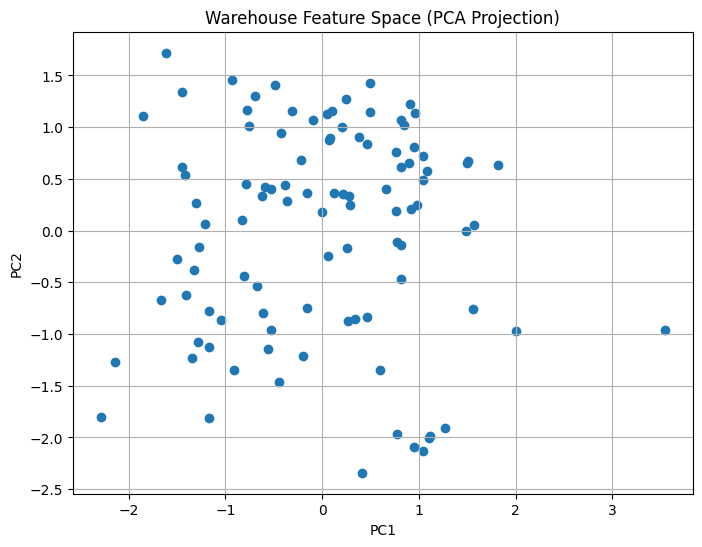

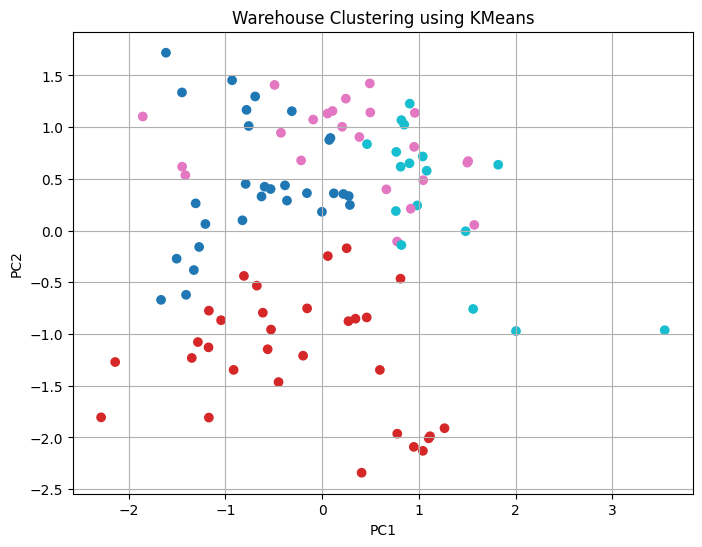

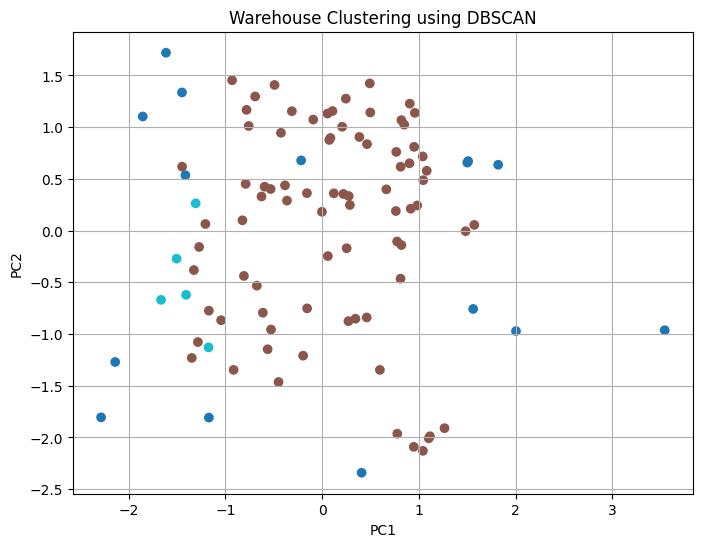

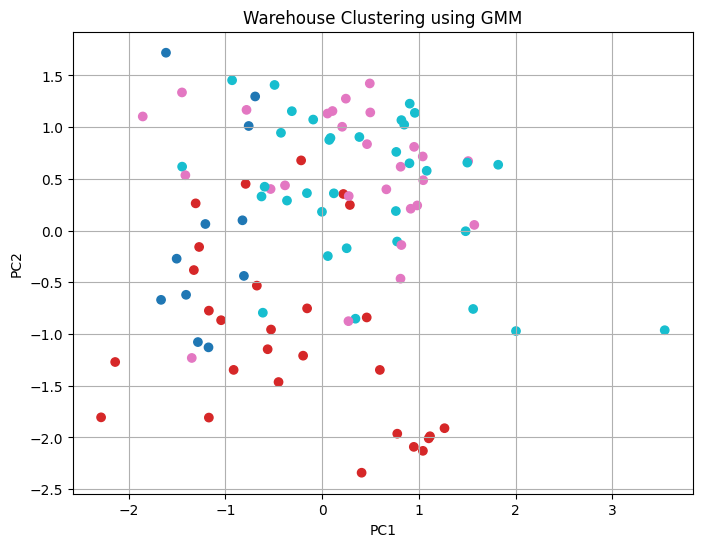

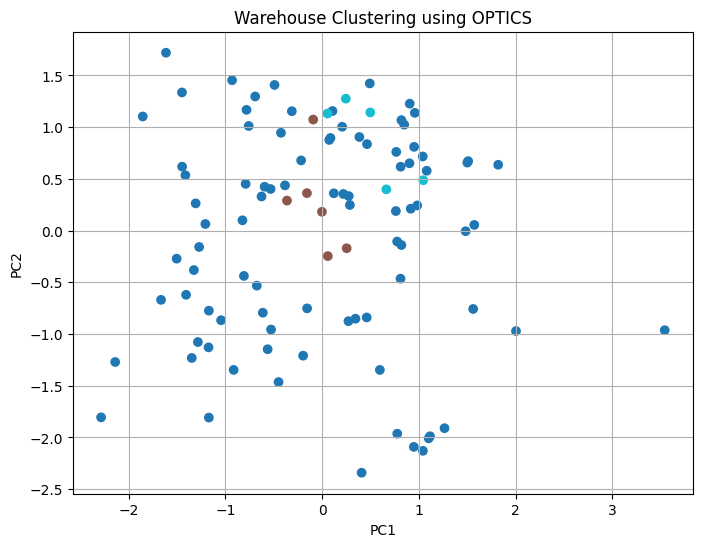

In [18]:
#3.1 Warehouse Clustering

# Step 1: Extract Warehouse-Level Info from Main Dataset
df_wh_cluster = df_encoded[[
    'warehouse_id', 'size-sqft', 'avg_dispatch_per_day',
    'manager-experience', 'Location_East', 'Location_North',
    'Location_South', 'Location_West', 'storage-type_cold', 'storage-type_Frozen'
]].drop_duplicates(subset='warehouse_id')

# Drop ID column before clustering
warehouse_features = df_wh_cluster.drop(columns=['warehouse_id'])

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(warehouse_features)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title("Warehouse Feature Space (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

#STEP 3: KMeans Clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
df_wh_cluster['kmeans_cluster'] = kmeans.fit_predict(warehouse_features)

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df_wh_cluster['kmeans_cluster'], cmap='tab10')
plt.title("Warehouse Clustering using KMeans")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

#STEP 4: DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=5)
df_wh_cluster['dbscan_cluster'] = dbscan.fit_predict(warehouse_features)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df_wh_cluster['dbscan_cluster'], cmap='tab10')
plt.title("Warehouse Clustering using DBSCAN")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

#STEP 5: Gaussian Mixture Model (GMM)
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, random_state=42)
df_wh_cluster['gmm_cluster'] = gmm.fit_predict(warehouse_features)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df_wh_cluster['gmm_cluster'], cmap='tab10')
plt.title("Warehouse Clustering using GMM")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

#STEP 6: OPTICS Clustering
from sklearn.cluster import OPTICS

optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)
df_wh_cluster['optics_cluster'] = optics.fit_predict(warehouse_features)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df_wh_cluster['optics_cluster'], cmap='tab10')
plt.title("Warehouse Clustering using OPTICS")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()



In [20]:
#KMeans Cluster Summary
# Combine features with cluster labels
kmeans_summary = df_wh_cluster.groupby('kmeans_cluster')[
    ['size-sqft', 'avg_dispatch_per_day', 'manager-experience']
].agg(['mean', 'std', 'min', 'max', 'count']).round(2)

print("📊 KMeans Cluster Summary:\n")
print(kmeans_summary)

#DBSCAN Cluster Summary
dbscan_summary = df_wh_cluster.groupby('dbscan_cluster')[
    ['size-sqft', 'avg_dispatch_per_day', 'manager-experience']
].agg(['mean', 'std', 'min', 'max', 'count']).round(2)

print("📊 DBSCAN Cluster Summary:\n")
print(dbscan_summary)

#GMM Cluster Summary
gmm_summary = df_wh_cluster.groupby('gmm_cluster')[
    ['size-sqft', 'avg_dispatch_per_day', 'manager-experience']
].agg(['mean', 'std', 'min', 'max', 'count']).round(2)

print("📊 GMM Cluster Summary:\n")
print(gmm_summary)

#OPTICS Cluster Summary
optics_summary = df_wh_cluster.groupby('optics_cluster')[
    ['size-sqft', 'avg_dispatch_per_day', 'manager-experience']
].agg(['mean', 'std', 'min', 'max', 'count']).round(2)

print("📊 OPTICS Cluster Summary:\n")
print(optics_summary)




📊 KMeans Cluster Summary:

               size-sqft                         avg_dispatch_per_day        \
                    mean   std   min   max count                 mean   std   
kmeans_cluster                                                                
0                  -1.02  0.70 -2.78 -0.09    29                 0.02  0.43   
1                   0.24  0.87 -1.52  1.82    31                -0.30  0.84   
2                   0.68  0.67 -0.55  1.86    23                -0.55  1.01   
3                   0.40  0.69 -0.32  2.17    17                 1.21  0.98   

                                 manager-experience                          
                 min   max count               mean   std   min   max count  
kmeans_cluster                                                               
0              -0.76  1.02    29               0.24  0.67 -1.18  1.29    29  
1              -3.47  0.95    31              -1.17  0.54 -1.95 -0.04    31  
2              -3.37  0.40   

In [21]:
#PHASE 3B: Supplier Clustering

#Step 1: Prepare Supplier Features
from sklearn.preprocessing import StandardScaler
# Select relevant features
supplier_features = d_sup[['avg_rating', 'compliance_score', 'total_products_supplied']].copy()

# Scale
scaler = StandardScaler()
supplier_scaled = scaler.fit_transform(supplier_features)

#kmeans
from sklearn.cluster import KMeans

kmeans_s = KMeans(n_clusters=3, random_state=42)
supplier_features['kmeans_cluster'] = kmeans_s.fit_predict(supplier_scaled)

#GMM
from sklearn.mixture import GaussianMixture

gmm_s = GaussianMixture(n_components=3, random_state=42)
supplier_features['gmm_cluster'] = gmm_s.fit_predict(supplier_scaled)

#agglomerative
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=3)
supplier_features['agglo_cluster'] = agglo.fit_predict(supplier_scaled)

summary = supplier_features.groupby('kmeans_cluster')[
    ['avg_rating', 'compliance_score', 'total_products_supplied']
].agg(['mean', 'std', 'min', 'max', 'count'])

print("Supplier KMeans Cluster Summary:")
print(summary.round(2))


Supplier KMeans Cluster Summary:
               avg_rating                         compliance_score        \
                     mean   std   min   max count             mean   std   
kmeans_cluster                                                             
0                    4.71  0.22  4.44  4.92     5             0.76  0.11   
1                    2.99  0.40  2.59  3.79    11             0.72  0.13   
2                    3.97  0.51  3.26  4.87    14             0.36  0.19   

                                 total_products_supplied                      
                 min   max count                    mean   std min max count  
kmeans_cluster                                                                
0               0.65  0.90     5                   12.60  2.51   9  16     5  
1               0.51  0.93    11                   16.82  3.79   9  21    11  
2               0.03  0.65    14                   18.00  3.59  11  23    14  


In [23]:
# PHASE 3C: Anomaly Detection on Shipments (Lost/Delayed)

# Step 1: Prepare Shipment Features
anomaly_df = df_encoded.copy()

# Drop only existing ID/timestamp columns (if they exist)
drop_cols = ['shipment_id', 'product_id', 'warehouse_id', 'dispatch_time', 'arrival_time', 'delivery_status']
drop_cols_existing = [col for col in drop_cols if col in anomaly_df.columns]
anomaly_df = anomaly_df.drop(columns=drop_cols_existing)

# Step 2: Apply Isolation Forest
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.03, random_state=42)
anomaly_df['anomaly_score'] = iso.fit_predict(anomaly_df)

# -1 = anomaly, 1 = normal
anomaly_df['is_anomaly'] = (anomaly_df['anomaly_score'] == -1).astype(int)

# Step 3: Analyze Results
print("🔍 Anomaly Count:\n", anomaly_df['is_anomaly'].value_counts())


🔍 Anomaly Count:
 is_anomaly
0    9700
1     300
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


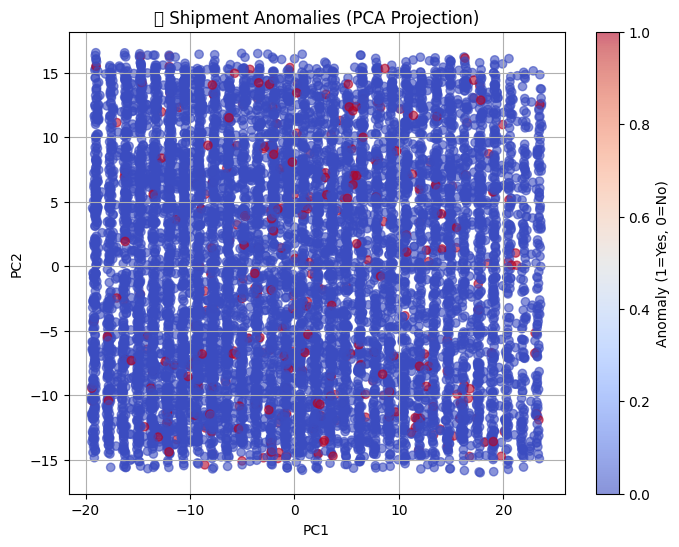

                               Normal       Anomaly
shipment_id              15000.802887  14957.373333
dispatch_year             2023.000000   2023.000000
arrival_year              2023.000000   2023.000000
product_id                1249.667629   1254.386667
warehouse_id              1049.654330   1052.600000
supplier_id                514.368247    515.423333
supplier_id_               514.224227    513.146667
total_products_supplied     16.709897     15.876667
arrival_day                 14.503402     15.840000
dispatch_day                14.383402     15.766667
📌 LOF Anomaly Count:
 lof_anomaly
0    9700
1     300
Name: count, dtype: int64


In [24]:
#Step A: Visualize Anomalies using PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Drop the anomaly columns for PCA
features = anomaly_df.drop(columns=['anomaly_score', 'is_anomaly'])

# Reduce dimensions
pca = PCA(n_components=2)
components = pca.fit_transform(features)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1],
            c=anomaly_df['is_anomaly'], cmap='coolwarm', alpha=0.6)
plt.title('📉 Shipment Anomalies (PCA Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Anomaly (1=Yes, 0=No)')
plt.grid(True)
plt.show()


#Step B: Analyze Feature Impact in Anomalies
# Join with original labels
df_analyzed = df_encoded.copy()
df_analyzed['is_anomaly'] = anomaly_df['is_anomaly']

# Compare means between anomalous and normal
anomaly_summary = df_analyzed.groupby('is_anomaly').mean(numeric_only=True).T
anomaly_summary.columns = ['Normal', 'Anomaly']
print(anomaly_summary.sort_values('Anomaly', ascending=False).head(10))

# Step C: Try Local Outlier Factor (LOF)
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.03)
lof_pred = lof.fit_predict(features)

# Convert to 0/1
anomaly_df['lof_anomaly'] = (lof_pred == -1).astype(int)
print("📌 LOF Anomaly Count:\n", anomaly_df['lof_anomaly'].value_counts())


In [30]:
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder

# Step 1: Prepare transaction data (product list per shipment)
basket_data = df_encoded[['shipment_id', 'product_id']].drop_duplicates()
transaction_df = basket_data.groupby('shipment_id')['product_id'].apply(list).reset_index()

# Step 2: Encode to one-hot format
te = TransactionEncoder()
te_array = te.fit(transaction_df['product_id']).transform(transaction_df['product_id'])
df_basket = pd.DataFrame(te_array, columns=te.columns_)

# Step 3: Apriori
min_support_val = 0.001
frequent_apriori = apriori(df_basket, min_support=min_support_val, use_colnames=True)

if not frequent_apriori.empty:
    rules_apriori = association_rules(frequent_apriori, metric='lift', min_threshold=1.0)
    print(f"🧾 Apriori Rules (Top 10 by Lift, min_support={min_support_val}):")
    print(rules_apriori.sort_values('lift', ascending=False).head(10))
else:
    print(f"⚠️ Apriori: No frequent itemsets found (min_support={min_support_val}). Try lowering further or check item frequency.")

# Step 4: FP-Growth
frequent_fpgrowth = fpgrowth(df_basket, min_support=min_support_val, use_colnames=True)

if not frequent_fpgrowth.empty:
    rules_fp = association_rules(frequent_fpgrowth, metric='lift', min_threshold=1.0)
    print(f"\n📊 FP-Growth Rules (Top 10 by Lift, min_support={min_support_val}):")
    print(rules_fp.sort_values('lift', ascending=False).head(10))
else:
    print(f"⚠️ FP-Growth: No frequent itemsets found (min_support={min_support_val}). Try lowering further.")


#I cannot perform Apriori or FP-Growth directly
#✅ Because these algorithms require multiple products per transaction (i.e., product bundles or baskets)

🧾 Apriori Rules (Top 10 by Lift, min_support=0.001):
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []

📊 FP-Growth Rules (Top 10 by Lift, min_support=0.001):
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []
